In [2]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean

from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/180324_Zcard_v_full/showers_df_evaluation/0_100_fcc.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/180324_Zcard_v_full/showers_df_evaluation/0_0_400.pt"
sd_hgb2, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/180324_Zcard_v_full/showers_df_evaluation/0_0_0.pt"
sd_hgb3, matched_hgb = open_mlpf_dataframe(path_hgcal, False)

In [4]:

path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/180324_Zcard_v_full/showers_df_evaluation/200_400.pt"
sd_hgb1, matched_hgb = open_mlpf_dataframe(path_hgcal, False)

In [22]:
allsd =  pd.concat([sd_hgb,sd_hgb1, sd_hgb2,sd_hgb3 ])

In [75]:

def create_eff_dic(matched_, log, num_hits_min=0, num_hits_max=5000):
    mask1 = matched_["reco_showers_E"] > num_hits_min
    mask2 = matched_["reco_showers_E"] < num_hits_max
    matched_ = matched_[mask1 * mask2]
    df_id = matched_
    photons_dic = calculate_eff(df_id, log)

    return photons_dic


def calculate_eff(sd, log_scale=False):
    # if log_scale:
    #     bins = np.exp(np.arange(np.log(0.0001), np.log(50), 0.5))
    # else:
    #     bins = np.arange(0, 51, 2)
    bins = np.exp(np.arange(np.log(1e-1), np.log(50), 0.2))
    # bins = [5e-3,0.1,1.80804241e-01,2.98095799e-01, 4.91476884e-01, 8.10308393e-01, 1.33597268e+00,2.20264658e+00, 3.63155027e+00, 5.98741417e+00, 9.87157710e+00,1.62754791e+01, 2.68337287e+01, 4.42413392e+01]
    bins = np.array(bins)
    eff = []
    energy_eff = []
    size_energy_bin = []
    errors = []
    total_showers_ = []
    number_of_hits = []
    number_of_hits_var = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.true_showers_E.values <= bin_i1
        mask_below = sd.true_showers_E.values > bin_i
        mask = mask_below * mask_above
        mask_non_nan = ~np.isnan(sd.e_pred_and_truth.values)
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            # eff.append(
            #     (total_showers - number_of_non_reconstructed_showers) / total_showers
            # )

            particle_purity = sd["e_pred_and_truth"][mask].values/sd["reco_showers_E"][mask].values
            track_purity = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            
            total_reconstructed_cld_crit =  np.sum((particle_purity>=0.5)*(track_purity>=0.5))
            eff.append(total_reconstructed_cld_crit/total_showers)
            energy_eff.append((bin_i1 + bin_i) / 2)
            size_energy_bin.append((bin_i1-bin_i)/2)
            total_showers_.append(total_showers)

            percentage_of_hits_MC = sd["e_pred_and_truth"][mask*mask_non_nan].values/sd["reco_showers_E"][mask*mask_non_nan].values
            number_of_hits.append(np.mean(percentage_of_hits_MC))

            n_r = sd["e_pred_and_truth"][mask*mask_non_nan].values
            n_t = sd["reco_showers_E"][mask*mask_non_nan].values
            error_percentage_of_hits = (n_r/(n_t**2)*np.sqrt(n_t))**2+(1/n_t*np.sqrt(n_r))**2
            N = len(error_percentage_of_hits)
            number_of_hits_var.append(1/N*np.sqrt(np.sum(error_percentage_of_hits)))
            n_total = total_showers
            n_r = total_showers - number_of_non_reconstructed_showers
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            error = np.sqrt(error)
            errors.append(error)
        if (bin_i>19) and (bin_i1<30):
            print(
                "bin",
                bin_i1,
                bin_i,
                (total_showers - number_of_non_reconstructed_showers) / total_showers,
                total_showers,
                (total_showers - number_of_non_reconstructed_showers),
                error
            )
        photons_dic = {}
        photons_dic["eff"] = eff
        photons_dic["energy_eff"] = energy_eff
        photons_dic["total_showers_"] = total_showers_
        photons_dic["size_energy_bin"] = size_energy_bin
        photons_dic["errors"] = errors
        photons_dic["number_of_hits"] = number_of_hits
        photons_dic["number_of_hits_var"]= number_of_hits_var 

    return photons_dic


In [86]:
## CUTS
log = True
# plt.figure()
mask_reco = allsd.reco_showers_E>15
mask_delta = allsd.delta_MC>0.02
mask_dc_hits = allsd.cdc_hits>4
mask_pt = allsd.true_showers_E>5e-3
sd_hgb_ = allsd[mask_reco*mask_delta*mask_dc_hits*mask_pt]
sd_hgb_mc = allsd[mask_reco*mask_dc_hits*mask_pt]


all_particles = create_eff_dic(sd_hgb_, log)
all_particles_dc = calculate_eff_DeltaMC(sd_hgb_mc)

particle_purity = sd_hgb_["e_pred_and_truth"].values/sd_hgb_["reco_showers_E"].values
track_purity = sd_hgb_["e_pred_and_truth"].values/sd_hgb_["pred_showers_E"].values
good_ml = np.sum((particle_purity>=0.5)*(track_purity>=0.5))/len(sd_hgb_)
split_ml = np.sum((particle_purity<0.5)*(track_purity>=0.5))/len(sd_hgb_)
multiple_ml = np.sum((particle_purity>=0.5)*(track_purity<0.5))/len(sd_hgb_)
bad_ml = np.sum((particle_purity<0.5)*(track_purity<0.5))/len(sd_hgb_)
nan_ml = np.sum(np.isnan(particle_purity))/len(sd_hgb_)

print(good_ml,split_ml, multiple_ml,bad_ml,nan_ml )
# plt.xscale("log")

bin 27.042640742615404 22.14064162041882 0.9851015801354401 2215 2182 0.02971289786385066
0.9803275338323467 0.00421367287489219 0.0019293183652404028 4.8492741675701326e-05 0.013480982185844969


In [59]:
# import seaborn as sns
# plt.figure()
# bins = np.exp(np.arange(np.log(0.001), np.log(80), 0.5))
# sns.histplot(sd_hgb_.true_showers_E, bins=bins)
# plt.xscale("log")

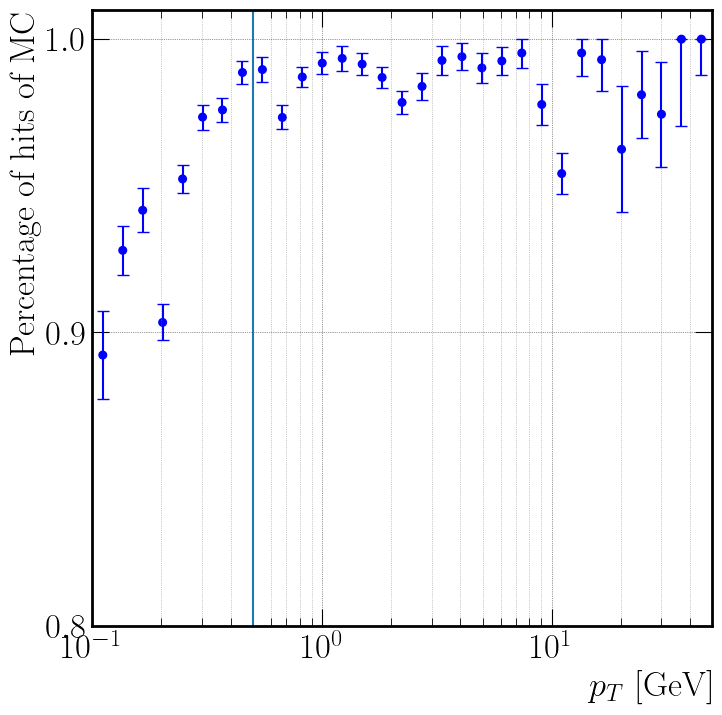

In [64]:
def limit_error_bars(y, yerr, upper_limit=1):
    yerr_upper = np.minimum(y + yerr, upper_limit) - y
    yerr_lower = yerr  # Lower error bars remain unchanged
    return yerr_lower, yerr_upper
fig= plt.figure( figsize=(8, 8))
axs = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = [ "b"]
marker = ["o"]
dataframe_list = [all_particles]
i =0 
plot_title =""
log = True
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("Percentage of hits of MC")

for i in range(0, len(dataframe_list)):
    axs.scatter(
        dataframe_list[i]["energy_eff"],
        dataframe_list[i]["eff"],
        label="Model " ,
        marker="o",
        c = [colors[i] for j in range(0,len(dataframe_list[i]["eff"]))],
        s=30,
    )
    error_y = dataframe_list[i]["errors"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["eff"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["eff"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)

    # axs.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["eff"] , xerr=dataframe_list[i]["size_energy_bin"]/2,yerr= dataframe_list[i]["errors"], linestyle='none')

if log:
    log_ = "log"
    axs.set_xscale("log")
else:
    log_ = ""
axs.set_ylim([0.7, 1.01])
# axs.legend(loc="lower left")
axs.axvline(x=0.1)
axs.axvline(x=0.5)

# axs.axvline(x=10)
# axs.set_yticks(ticks=[0.7, 0.8, 0.9, 1])
# axs.set_xticks(ticks=[0.01, 0.01, 0.1, 1, 10, 50])
# axs.tick_params(axis='x', labelsize=30)
# axs.tick_params(axis='y', labelsize=30)
axs.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
axs.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
axs.yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs.grid(which='major', linestyle=':', linewidth='0.5', color='black')
axs.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlim([1e-1,50])
plt.ylim([0.8,1.01])
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
size_font = 25
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10

# leg._legend_box.align = "right"


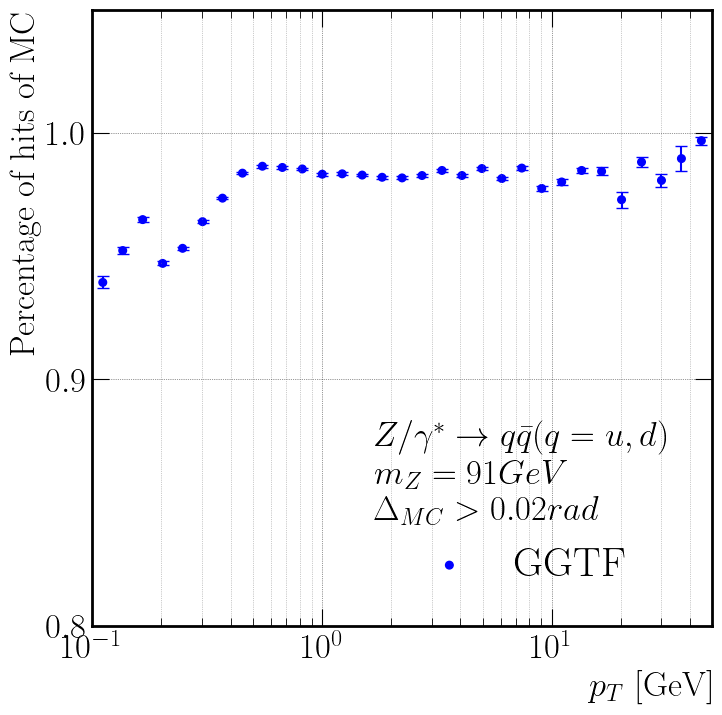

In [84]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(8, 8))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["b"]
marker = [ "o"]
labels = [ "GGTF"]
dataframe_list = [all_particles]
i =0 
log = True
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("Percentage of hits of MC")

for i in range(0, len(dataframe_list)):
    plt.scatter(
        np.array(dataframe_list[i]["energy_eff"]),
        np.array(dataframe_list[i]["number_of_hits"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["number_of_hits"]))],
        s=30,
    )
    error_y = dataframe_list[i]["number_of_hits_var"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["number_of_hits"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["number_of_hits"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)

if log:
    log_ = "log"
    plt.xscale("log")
else:
    log_ = ""
# plt.title("CLD")
plt.legend(loc="lower right",title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d)$' "\n" r"$m_Z=91GeV$" "\n" r"$\Delta_{MC}>0.02 rad$")


ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.grid(True, which="minor")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.xlim([1e-1,50])
plt.ylim([0.8,1.05])
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] =size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 30

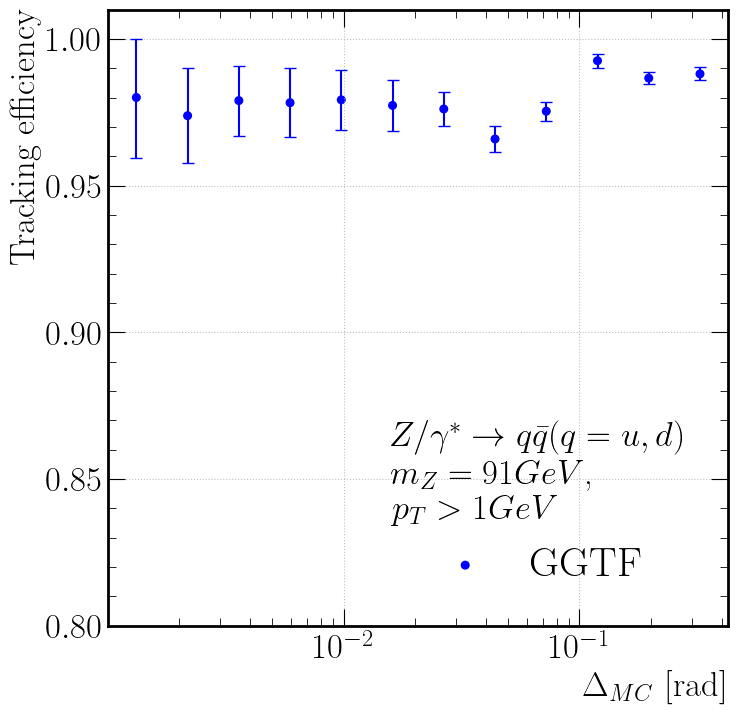

In [85]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(8, 8))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["b"]
marker = [ "o"]
labels = [ "GGTF"]
dataframe_list = [all_particles_dc]
i =0 
log = True
plt.xlabel("$\Delta_{MC}$ [rad]")
plt.ylabel("Tracking efficiency")

for i in range(0, len(dataframe_list)):
    plt.scatter(
        np.array(dataframe_list[i]["delta_MC_values"]),
        np.array(dataframe_list[i]["eff_delta_MC"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["eff_delta_MC"]))],
        s=30,
    )
    error_y = dataframe_list[i]["errors_delta_mc"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["eff_delta_MC"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["delta_MC_values"], dataframe_list[i]["eff_delta_MC"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)


# plt.title("CLD")
plt.legend(loc="lower right",title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d)$' "\n" r'$m_Z=91GeV$,' "\n" r"$p_T>1 GeV$")
plt.xscale("log")
# ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
# ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(True)
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# plt.xlim([1e-1,50])
plt.ylim([0.8,1.01])

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10

In [66]:

def calculate_eff_DeltaMC(sd, log_scale=False):

    bins = np.exp(np.arange(np.log(1e-3), np.log(0.5), 0.5))
    eff = []
    energy_eff = []
    total_showers_ = []
    errors_delta_mc = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.delta_MC.values <= bin_i1
        mask_below = sd.delta_MC.values > bin_i
        mask = mask_below * mask_above
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            eff.append(
                (total_showers - number_of_non_reconstructed_showers) / total_showers
            )
            n_r = (total_showers - number_of_non_reconstructed_showers)
            n_total = total_showers
            energy_eff.append((bin_i1 + bin_i) / 2)
            total_showers_.append(total_showers)
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            error = np.sqrt(error)
            errors_delta_mc.append(error)
    photons = {}
    photons["eff_delta_MC"]= eff
    photons["delta_MC_values"]=energy_eff
    photons["errors_delta_mc"]=errors_delta_mc
    return photons

In [93]:
from src.logger.plotting_tools import shuffle_truth_colors
label_print = dic["graph"].ndata['particle_number'].view(-1).clone()
mask = label_print==4
tidx = label_print.view(-1)
features =  dic["graph"].ndata["e_hits"]
pos_hits =dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
rdst = np.random.RandomState(1234567890)  # all the same
#shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
# hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [145]:

store_image(label=False, cluster=False, pandora=True)

In [ ]:
store_image(label=True, cluster=False)

In [49]:
store_image(label=True, cluster=False)
store_image(label = False, cluster=False)
store_image(label=False, cluster=True)
store_image(label = True, cluster=True)
store_image(label = True, true_false=True)

In [10]:
def plot_iou_matrix(iou_matrix, image_path):
    iou_matrix = torch.transpose(iou_matrix[1:, :], 1, 0)
    fig, ax = plt.subplots()
    iou_matrix = iou_matrix.detach().cpu().numpy()
    ax.matshow(iou_matrix, cmap=plt.cm.Blues)
    for i in range(0, iou_matrix.shape[1]):
        for j in range(0, iou_matrix.shape[0]):
            c = np.round(iou_matrix[j, i], 1)
            ax.text(i, j, str(c), va="center", ha="center")

In [11]:
def store_image(label=False, cluster = False, pandora = False, true_false=False):
    if label:
        tidx = np.reshape(labels, (-1,1)) 
    elif pandora:
        if true_false:
            tidx = np.reshape(label_matched_pandora, (-1,1)) 
        else:
            tidx = np.reshape(labels_pandora, (-1,1))
    elif true_false:
        tidx = np.reshape(label_matched, (-1,1)) 
    else:
        tidx = dic["graph"].ndata['particle_number'].view(-1,1)
    features =  torch.log(dic["graph"].ndata["e_hits"])+10
    pos_hits =dic["graph"].ndata["pos_hits_xyz"]
    if cluster:
        pos_hits = X
    data = {
                "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
                "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
                "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
                "tIdx": tidx,
                "features": features.view(-1, 1).detach().cpu().numpy(),
            }
    hoverdict = {}
    # if hoverfeat is not None:
    #     for j in range(hoverfeat.shape[1]):
    #         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
    #     data.update(hoverdict)

    # if nidx is not None:
    #     data.update({"av_same": av_same})

    df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
    )
    df["orig_tIdx"] = df["tIdx"]
    rdst = np.random.RandomState(1234567890)  # all the same
    #shuffle_truth_colors(df, "tIdx", rdst)

    # hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
    # if nidx is not None:
    #     hover_data.append("av_same")
    fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size="features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
    )
    fig.update_traces(marker=dict(line=dict(width=0)))
    if pandora and true_false:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label_true_false.html"
    elif true_false:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label__true_false.html"
    elif label and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label.html"
    elif pandora and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label.html"
    elif label and cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_cluster.html"
    elif not label and  cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_cluster.html"
    else:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label.html"
    fig.write_html(path)